## 1. Import Library

In [90]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [91]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

## 3. LightGBM Modeling

In [95]:
pred_dict = {}
pred_test_dict = {}

### (1) HP Tuning

In [92]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

In [93]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.001, 0.01),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 None을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return log_loss(train_y, cv)

In [113]:
sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=5)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-15 00:38:08,506] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-15 00:43:16,968] Trial 0 finished with value: 0.6236366747218378 and parameters: {'learning_rate': 0.004370861069626263, 'reg_alpha': 0.9507143064099162, 'reg_lambda': 0.7319939418114051, 'max_depth': 7, 'num_leaves': 356, 'colsample_bytree': 0.15599452033620265, 'subsample': 0.05808361216819946, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 327}. Best is trial 0 with value: 0.6236366747218378.


multi_logloss: 0.6236366747218378
accuracy_score: 0.769593147751606


[I 2022-03-15 00:51:57,627] Trial 1 finished with value: 0.5710599187087119 and parameters: {'learning_rate': 0.001185260448662222, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'max_depth': 5, 'num_leaves': 382, 'colsample_bytree': 0.18340450985343382, 'subsample': 0.3042422429595377, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 223}. Best is trial 1 with value: 0.5710599187087119.


multi_logloss: 0.5710599187087119
accuracy_score: 0.7991434689507495


[I 2022-03-15 00:55:13,698] Trial 2 finished with value: 0.4763990734207638 and parameters: {'learning_rate': 0.006506676052501416, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'max_depth': 6, 'num_leaves': 656, 'colsample_bytree': 0.7851759613930136, 'subsample': 0.19967378215835974, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 161}. Best is trial 2 with value: 0.4763990734207638.


multi_logloss: 0.4763990734207638
accuracy_score: 0.8346895074946467


[I 2022-03-15 00:58:18,101] Trial 3 finished with value: 0.44771800074381773 and parameters: {'learning_rate': 0.006467903667112946, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.8083973481164611, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260}. Best is trial 3 with value: 0.44771800074381773.


multi_logloss: 0.44771800074381773
accuracy_score: 0.8355460385438972


[I 2022-03-15 01:11:51,521] Trial 4 finished with value: 0.46516486731490825 and parameters: {'learning_rate': 0.0020983441136030096, 'reg_alpha': 0.4951769101112702, 'reg_lambda': 0.034388521115218396, 'max_depth': 8, 'num_leaves': 459, 'colsample_bytree': 0.662522284353982, 'subsample': 0.31171107608941095, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 196}. Best is trial 3 with value: 0.44771800074381773.


multi_logloss: 0.46516486731490825
accuracy_score: 0.8342612419700214
The best hyperparameters are:
 {'learning_rate': 0.006467903667112946, 'reg_alpha': None, 'reg_lambda': None, 'max_depth': 8, 'num_leaves': 1166, 'colsample_bytree': 0.8083973481164611, 'subsample': 0.3046137691733707, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260, 'objective': 'multiclass', 'n_estimators': 10000, 'lambda_l1': 0.17052412368729153, 'lambda_l2': 0.06505159298527952}


/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/2686553518.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(lgb_study);


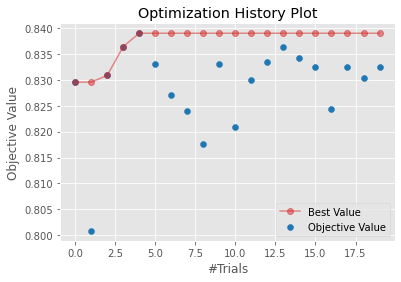

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(lgb_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/3200258722.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(lgb_study);


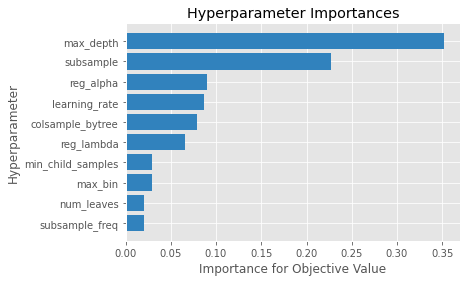

In [8]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/1653781200.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(lgb_study);


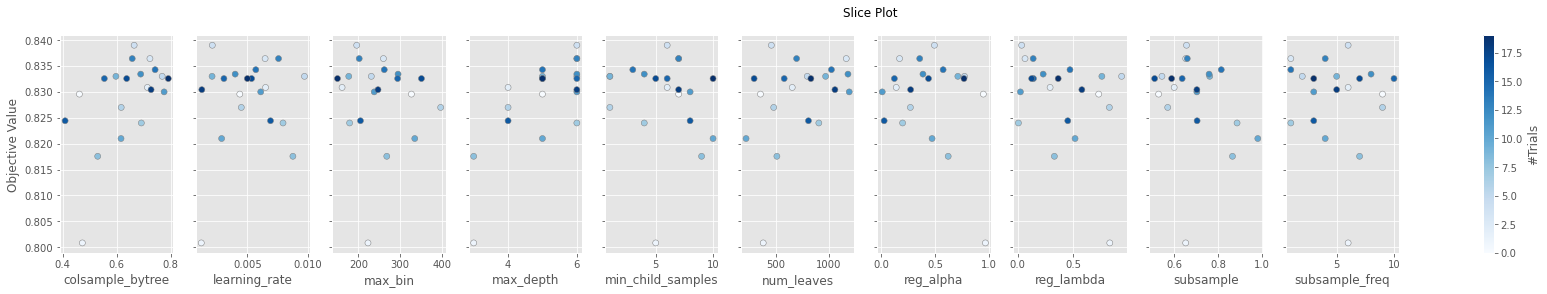

In [9]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

### (2) Training

In [109]:
lucky_seeds = [2283, 8217, 91373] # Lucky seed 늘려가면서 하기

# lgb_pred = np.zeros((test_x.shape[0], 4))

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print(f"{n+1} Fold Training.....")
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None)
        
        cv[val_idx,:] = lgbmodel.predict_proba(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += lgbmodel.predict_proba(test_x) / 5 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

#         val_cls = np.argmax(val_pred, axis=1)

#         fold_lgb_acc = accuracy_score(y_val, val_cls)
#         lgb_acc.append(fold_lgb_acc)

#         print(f'fold{n+1} score: {fold_lgb_acc}')
#         fold_pred = lgbmodel.predict_proba(test_x) / skf.n_splits
#         lgb_pred += fold_pred

1 Fold Training.....
2 Fold Training.....
3 Fold Training.....
4 Fold Training.....
5 Fold Training.....
2283 multi_logloss : 0.624807021164982
2283 accuracy_score : 0.7725910064239828

1 Fold Training.....
2 Fold Training.....
3 Fold Training.....
4 Fold Training.....
5 Fold Training.....
8217 multi_logloss : 0.637241810169812
8217 accuracy_score : 0.7708779443254818

1 Fold Training.....
2 Fold Training.....


KeyboardInterrupt: 

In [11]:
np.mean(lgb_acc)

0.8338329764453961

## 4. CNN Modeling

### (1) HP Tuning

In [12]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [73]:
def create_model(filter_1, filter_2, mid_units):
    
    model = Sequential()
    model.add(Conv2D(filters=filter_1, kernel_size=(2, 2), padding="same", activation="elu", input_shape=(8, 4, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=filter_2, kernel_size=(2, 2), padding="same", activation="elu"))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [74]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 64, 128, 16))
    
    #number of the each convolution layer filter
    filter_1 = int(trial.suggest_discrete_uniform("filter_1", 64, 128, 32))
    filter_2 = int(trial.suggest_discrete_uniform("filter_2", 128, 256, 32))

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(filter_1, filter_2, mid_units)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [76]:
## sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=30)

[I 2022-03-14 15:51:22,567] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-14 15:53:56,961] Trial 0 finished with value: 0.8638115631691649 and parameters: {'mid_units': 112.0, 'filter_1': 96.0, 'filter_2': 256.0, 'learning_rate': 0.0034592580153515453}. Best is trial 0 with value: 0.8638115631691649.


multi_logloss: 0.3947274313756866
accuracy_score: 0.8638115631691649


[I 2022-03-14 15:55:41,731] Trial 1 finished with value: 0.8655246252676659 and parameters: {'mid_units': 96.0, 'filter_1': 64.0, 'filter_2': 160.0, 'learning_rate': 0.0016934106545677646}. Best is trial 1 with value: 0.8655246252676659.


multi_logloss: 0.37680458896341046
accuracy_score: 0.8655246252676659


[I 2022-03-14 15:58:19,447] Trial 2 finished with value: 0.867237687366167 and parameters: {'mid_units': 80.0, 'filter_1': 128.0, 'filter_2': 160.0, 'learning_rate': 0.0045142094982970095}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.40864410335780815
accuracy_score: 0.867237687366167


[I 2022-03-14 16:00:30,104] Trial 3 finished with value: 0.860813704496788 and parameters: {'mid_units': 112.0, 'filter_1': 128.0, 'filter_2': 192.0, 'learning_rate': 0.0030960674808186163}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.40732177754482435
accuracy_score: 0.860813704496788


[I 2022-03-14 16:02:45,033] Trial 4 finished with value: 0.8633832976445396 and parameters: {'mid_units': 96.0, 'filter_1': 64.0, 'filter_2': 224.0, 'learning_rate': 0.0017634756309838511}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.3878568204353969
accuracy_score: 0.8633832976445396


[I 2022-03-14 16:04:48,683] Trial 5 finished with value: 0.862526766595289 and parameters: {'mid_units': 64.0, 'filter_1': 96.0, 'filter_2': 128.0, 'learning_rate': 0.004732063629588114}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.41679607758538456
accuracy_score: 0.862526766595289


[I 2022-03-14 16:07:35,876] Trial 6 finished with value: 0.8612419700214132 and parameters: {'mid_units': 128.0, 'filter_1': 128.0, 'filter_2': 160.0, 'learning_rate': 0.0005695547743799034}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.38714367914850917
accuracy_score: 0.8612419700214132


[I 2022-03-14 16:09:40,039] Trial 7 finished with value: 0.8565310492505354 and parameters: {'mid_units': 128.0, 'filter_1': 96.0, 'filter_2': 256.0, 'learning_rate': 0.004836289896901639}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.4190098031627161
accuracy_score: 0.8565310492505354


[I 2022-03-14 16:11:22,644] Trial 8 finished with value: 0.8578158458244112 and parameters: {'mid_units': 128.0, 'filter_1': 64.0, 'filter_2': 160.0, 'learning_rate': 0.004330115021825856}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.41008178450233446
accuracy_score: 0.8578158458244112


[I 2022-03-14 16:13:30,780] Trial 9 finished with value: 0.8650963597430407 and parameters: {'mid_units': 80.0, 'filter_1': 64.0, 'filter_2': 192.0, 'learning_rate': 0.004712696483723515}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.3776995640389656
accuracy_score: 0.8650963597430407


[I 2022-03-14 16:15:56,529] Trial 10 finished with value: 0.8586723768736617 and parameters: {'mid_units': 64.0, 'filter_1': 128.0, 'filter_2': 128.0, 'learning_rate': 0.00378807925318961}. Best is trial 2 with value: 0.867237687366167.


multi_logloss: 0.415326365970616
accuracy_score: 0.8586723768736617


[I 2022-03-14 16:18:52,853] Trial 11 finished with value: 0.8706638115631692 and parameters: {'mid_units': 80.0, 'filter_1': 96.0, 'filter_2': 160.0, 'learning_rate': 0.00218328661301112}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3967857855063529
accuracy_score: 0.8706638115631692


[I 2022-03-14 16:23:57,667] Trial 12 finished with value: 0.8638115631691649 and parameters: {'mid_units': 80.0, 'filter_1': 128.0, 'filter_2': 160.0, 'learning_rate': 0.0024046114589223793}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.39807379832762363
accuracy_score: 0.8638115631691649


[I 2022-03-14 16:26:04,091] Trial 13 finished with value: 0.8655246252676659 and parameters: {'mid_units': 80.0, 'filter_1': 96.0, 'filter_2': 128.0, 'learning_rate': 0.00256330359797155}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.38757697011880904
accuracy_score: 0.8655246252676659


[I 2022-03-14 16:28:04,915] Trial 14 finished with value: 0.8620985010706638 and parameters: {'mid_units': 80.0, 'filter_1': 96.0, 'filter_2': 192.0, 'learning_rate': 0.0018324526845631443}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.39229907950762494
accuracy_score: 0.8620985010706638


[I 2022-03-14 16:30:31,717] Trial 15 finished with value: 0.8638115631691649 and parameters: {'mid_units': 64.0, 'filter_1': 128.0, 'filter_2': 224.0, 'learning_rate': 0.0006856184428137035}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.39460712437769774
accuracy_score: 0.8638115631691649


[I 2022-03-14 16:32:20,418] Trial 16 finished with value: 0.854389721627409 and parameters: {'mid_units': 96.0, 'filter_1': 96.0, 'filter_2': 160.0, 'learning_rate': 0.003998364596356205}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.4135196225350415
accuracy_score: 0.854389721627409


[I 2022-03-14 16:35:27,915] Trial 17 finished with value: 0.8650963597430407 and parameters: {'mid_units': 80.0, 'filter_1': 128.0, 'filter_2': 224.0, 'learning_rate': 0.0011479765144562842}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3834423844526328
accuracy_score: 0.8650963597430407


[I 2022-03-14 16:38:24,511] Trial 18 finished with value: 0.8629550321199143 and parameters: {'mid_units': 96.0, 'filter_1': 96.0, 'filter_2': 192.0, 'learning_rate': 0.0030174911837991814}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3988127171064106
accuracy_score: 0.8629550321199143


[I 2022-03-14 16:39:58,044] Trial 19 finished with value: 0.8509635974304068 and parameters: {'mid_units': 64.0, 'filter_1': 128.0, 'filter_2': 128.0, 'learning_rate': 0.002432359399530639}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.4327528028837403
accuracy_score: 0.8509635974304068


[I 2022-03-14 16:42:38,449] Trial 20 finished with value: 0.867237687366167 and parameters: {'mid_units': 112.0, 'filter_1': 96.0, 'filter_2': 160.0, 'learning_rate': 0.002103132670515592}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3839490754173529
accuracy_score: 0.867237687366167


[I 2022-03-14 16:44:24,953] Trial 21 finished with value: 0.8603854389721627 and parameters: {'mid_units': 112.0, 'filter_1': 96.0, 'filter_2': 160.0, 'learning_rate': 0.0020576637633647594}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.4144443236450941
accuracy_score: 0.8603854389721627


[I 2022-03-14 16:46:20,765] Trial 22 finished with value: 0.8680942184154176 and parameters: {'mid_units': 112.0, 'filter_1': 96.0, 'filter_2': 160.0, 'learning_rate': 0.0012599863156297787}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3876232848738171
accuracy_score: 0.8680942184154176


[I 2022-03-14 16:48:52,987] Trial 23 finished with value: 0.8655246252676659 and parameters: {'mid_units': 96.0, 'filter_1': 96.0, 'filter_2': 192.0, 'learning_rate': 0.0013503479756070567}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3863330691320983
accuracy_score: 0.8655246252676659


[I 2022-03-14 16:50:59,520] Trial 24 finished with value: 0.8620985010706638 and parameters: {'mid_units': 112.0, 'filter_1': 96.0, 'filter_2': 128.0, 'learning_rate': 0.001148409951205165}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.39188403505906644
accuracy_score: 0.8620985010706638


[I 2022-03-14 16:52:55,713] Trial 25 finished with value: 0.8668094218415417 and parameters: {'mid_units': 80.0, 'filter_1': 64.0, 'filter_2': 160.0, 'learning_rate': 0.0013632786567124178}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.3874881475565775
accuracy_score: 0.8668094218415417


[I 2022-03-14 16:55:33,213] Trial 26 finished with value: 0.8663811563169165 and parameters: {'mid_units': 96.0, 'filter_1': 128.0, 'filter_2': 192.0, 'learning_rate': 0.0029409676594414624}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.38654264416821693
accuracy_score: 0.8663811563169165


[I 2022-03-14 16:57:42,292] Trial 27 finished with value: 0.860813704496788 and parameters: {'mid_units': 80.0, 'filter_1': 96.0, 'filter_2': 160.0, 'learning_rate': 0.0008523656466682711}. Best is trial 11 with value: 0.8706638115631692.


multi_logloss: 0.4119984995589226
accuracy_score: 0.860813704496788


[I 2022-03-14 16:59:58,158] Trial 28 finished with value: 0.8736616702355461 and parameters: {'mid_units': 64.0, 'filter_1': 128.0, 'filter_2': 128.0, 'learning_rate': 0.003428553362297737}. Best is trial 28 with value: 0.8736616702355461.


multi_logloss: 0.3774299914530875
accuracy_score: 0.8736616702355461


[I 2022-03-14 17:01:40,625] Trial 29 finished with value: 0.8586723768736617 and parameters: {'mid_units': 64.0, 'filter_1': 64.0, 'filter_2': 128.0, 'learning_rate': 0.0033832688480158173}. Best is trial 28 with value: 0.8736616702355461.


multi_logloss: 0.40803479181490204
accuracy_score: 0.8586723768736617


/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/1430751235.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(cnn_study);


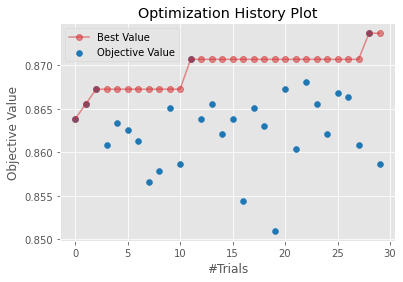

In [77]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/3633289961.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(cnn_study);


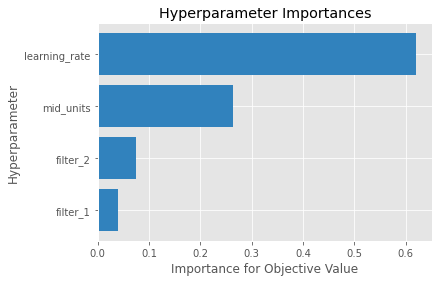

In [78]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/3328840784.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(cnn_study);


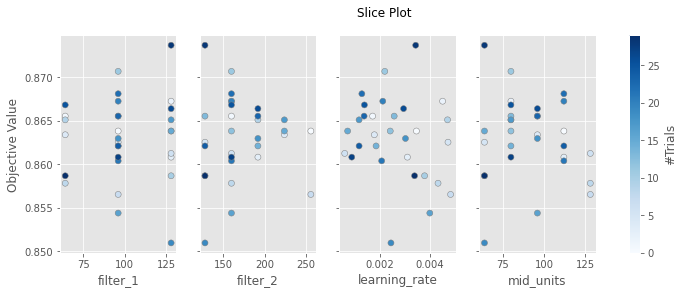

In [79]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [ ]:
lucky_seeds = [2283, 8217, 91373] # Lucky seed 늘려가면서 하기

# lgb_pred = np.zeros((test_x.shape[0], 4))

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print(f"{n+1} Fold Training.....")
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None)
        
        cv[val_idx,:] = lgbmodel.predict_proba(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += lgbmodel.predict_proba(test_x) / 5 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

#         val_cls = np.argmax(val_pred, axis=1)

#         fold_lgb_acc = accuracy_score(y_val, val_cls)
#         lgb_acc.append(fold_lgb_acc)

#         print(f'fold{n+1} score: {fold_lgb_acc}')
#         fold_pred = lgbmodel.predict_proba(test_x) / skf.n_splits
#         lgb_pred += fold_pred

In [82]:
lucky_seeds = [2283, 8217, 91373] # Lucky seed 늘려가면서 하기

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros((train_x.shape[0], 4))
    pred_test = np.zeros((test_x.shape[0], 4), dtype=float)
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    
    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):
#         print(f"{n+1} Fold Training.....")
        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]

        cnn = create_model(cnn_study.best_params['filter_1'], cnn_study.best_params['filter_2'], 
                           cnn_study.best_params['mid_units'])

        # ModelCheckpoint Fold마다 갱신
        mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)

        # 모델 Complie
        optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
        cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
        cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                callbacks=[es,mc], verbose=0)

        # 최고 성능 기록 모델
        best = load_model(f"model_{i+1}.h5")
        
        cv[val_idx,:] = best.predict(x_val)
        #print(f'fold{n+1} multi_logloss: {log_loss(y_val, cv[val_idx, :])}') # Fold마다 점수 체크하려면 주석 해제
        pred_test += best.predict(test_x) / 5 # CV 바꾸면 이 숫자도 똑같이 바꿔야함
    pred_dict['cnn'+str(seed)] = cv
    pred_test_dict['cnn'+str(seed)] = pred_test
#     print(f'seed {seed}', 'multi_logloss :', log_loss(train_y, cv))
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

1 Fold Training.....
1 Fold ACC of CNN = 0.8479657387580299

2 Fold Training.....
2 Fold ACC of CNN = 0.9014989293361885

3 Fold Training.....
3 Fold ACC of CNN = 0.8758029978586723

4 Fold Training.....
4 Fold ACC of CNN = 0.8394004282655246

5 Fold Training.....
5 Fold ACC of CNN = 0.8736616702355461



In [83]:
np.mean(cnn_acc)

0.8676659528907923

## 5. Submission

In [89]:
submission['target'] = np.argmax(
    lgb_pred * 0.2 +
    cnn_pred * 0.8,
    axis = 1)
submission.to_csv('submission/20220315-1.csv', index = False)
submission.target.value_counts()

1    2385
2    2378
3    2304
0    2276
Name: target, dtype: int64

In [59]:
submission['target'] = np.argmax(
    lgb_pred * 0.1 +
    cnn_pred * 0.9,
    axis = 1)
submission.to_csv('submission/20220314-1.csv', index = False)
submission.target.value_counts()

2    2461
1    2409
3    2282
0    2191
Name: target, dtype: int64